# 复现DeepWalk与Node2Vec代码并可视化

In [1]:
import networkx as nx
import json

import umap
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import pandas as pd
import numpy as np
from tqdm import tqdm
import random
from scipy.linalg import sqrtm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

from karateclub.utils.walker import RandomWalker, BiasedRandomWalker
from karateclub import DeepWalk, Node2Vec
from gensim.models.word2vec import Word2Vec

In [2]:
%matplotlib inline
mpl.rcParams['figure.figsize'] = 18, 7
pd.set_option('display.float_format', lambda x: '%.5f' % x)

There is another way to extract the structural information from the graph - node embedding. If you've ever worked with NLP, you'll know what I'm talking about. We want to represent the nodes in the n-dimensional vector form that reflects the structural properties of the graph. Sounds like a mouthful, so let's take a quick look at the example. 

### Karate Club Example
We are going to use famous Zachary's karate club dataset which comes with `NetworkX` package and `karateclub`'s implementation of the DeepWalk algorithm. Each student in the graph belongs to 1 of the 2 karate clubs - Officer or Mr. Hi. 

In [3]:
G = nx.karate_club_graph()  # load data

clubs = []  # list to populate with labels
for n in G.nodes:
    c = G.nodes[n]['club']  # karate club name, can be either 'Officer' or 'Mr. Hi'
    clubs.append(1 if c == 'Officer' else 0)

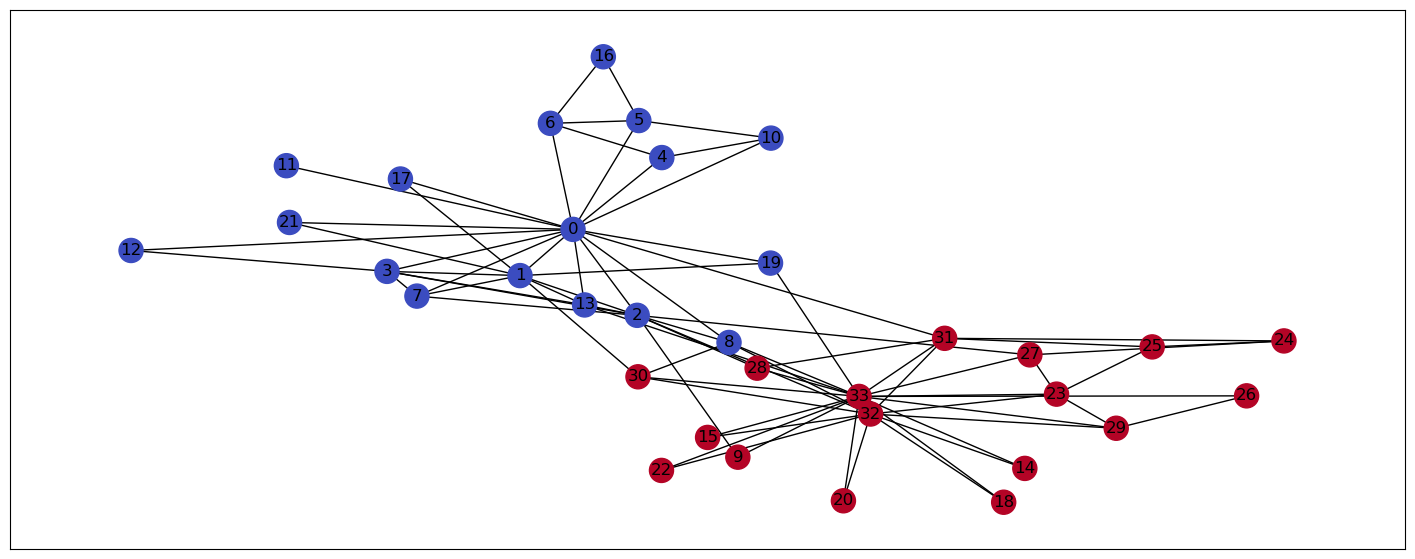

In [4]:
pos = nx.spring_layout(G, seed=42) # To be able to recreate the graph layout
nx.draw_networkx(G, pos=pos, node_color = clubs, cmap='coolwarm') # Plot the graph
plt.show()

As you can see, members of the karate clubs talk mainly to their club members. This information could be very valuable for e.g. classification or community detection tasks and we can represent it using the node embeddings.

In [5]:
model = DeepWalk(dimensions=124)  # node embedding algorithm
model.fit(G)  # fit it on the graph
embedding = model.get_embedding()  # extract embeddings

print('Number of karate club members:', len(G.nodes))
print('Embedding array shape:', embedding.shape)

Number of karate club members: 34
Embedding array shape: (34, 124)


c:\Users\34418\.conda\envs\deepwalk\lib\site-packages\karateclub\estimator.py:66: UserWarning: Please do be advised that the graph you have provided does not contain (some) edges in the main diagonal, for instance the self-loop constitued of (0, 0). These selfloops are necessary to ensure that the graph is traversable, and for this reason we create a copy of the graph and add therein the missing edges. Since we are creating a copy, this will immediately duplicate the memory requirements. To avoid this double allocation, you can provide the graph with the selfloops.
  warnings.warn(


Using DeepWalk (which is a black box algorithm for now) each karate club member is now represented by a vector of size 124. These vectors should reflect the graph structure, i.e. the different clubs should be far away from each other. We can check it by reducing the 124 dimensional data into 2 dimensional data using `umap-learn` package and making a scatter plot.

c:\Users\34418\.conda\envs\deepwalk\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\34418\.conda\envs\deepwalk\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


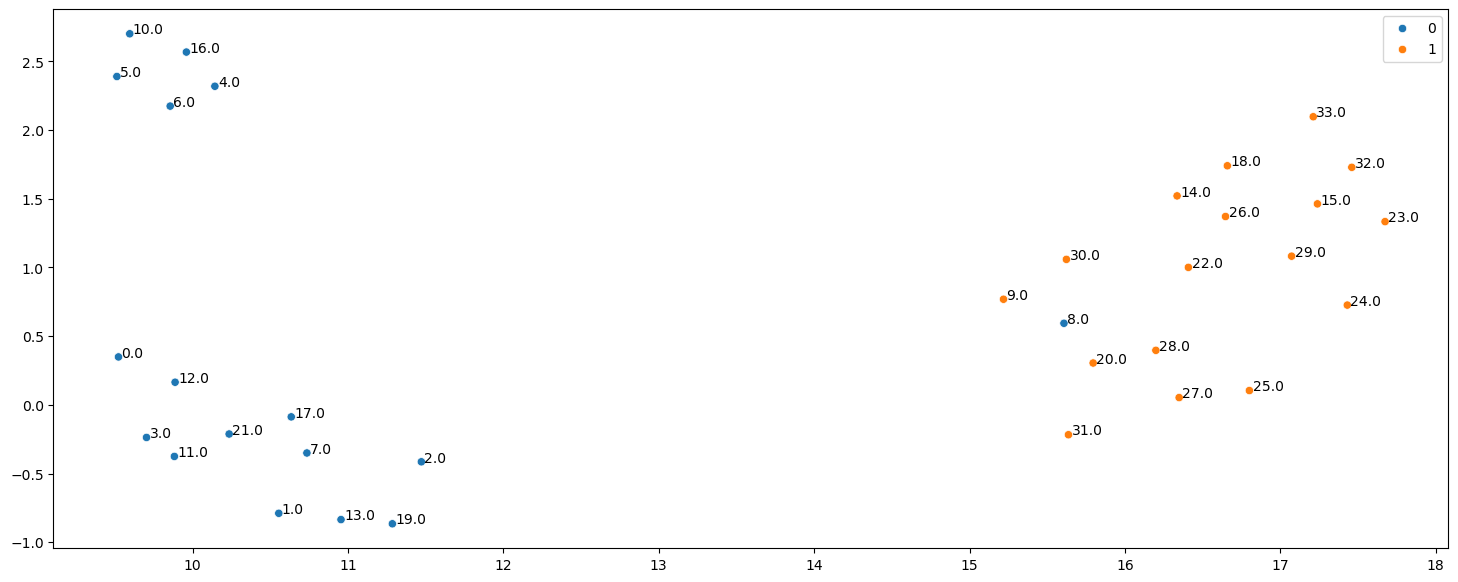

In [6]:
u = umap.UMAP(random_state=42)
umap_embs = u.fit_transform(embedding)

ax = sns.scatterplot(x = umap_embs[:, 0], y = umap_embs[:, 1], hue = clubs)
a = pd.DataFrame({'x': umap_embs[:, 0], 'y': umap_embs[:, 1], 'val': G.nodes})
for i, point in a.iterrows():
    ax.text(point['x']+.02, point['y'], str(point['val']))
plt.show()

As you can see, the embeddings did very well at representing the structure of the graph. Not only the two karate clubs are clearly separated but the members which are connected to the other clubs (e.g. nodes 28, 30, 8, and 2) are sort of more in the middle. In addition, the algorithm seems to have found a sub-community in the "Officer" karate club, which just shows how useful these embeddings can be. To summarise, **DeepWalk (and any other node embedding algorithm) tries to represent the nodes as vectors which capture some structural information from the graph.**

Now that you have an intuitive understanding of what are we trying to achieve, let's see how exactly DeepWalk does its magic. To do that, we first need to understand the concept of random walk on graph.

### Random Walk
Random walk is a sequence of nodes, where next node is chosen randomly from the adjacent nodes. For example, let's start our random walk from node 25. From the graph above we can see that the node 25 (right-most) is connected to the nodes 24 and 31. Hence, using a coin-flip we'll determine where we go next. If we've arrived at the node 24, we can see that it's connected to the members 23, 27, and 31. Again, we need to choose randomly where to go next. This "walk" continues until we've reached the desired walk length. Let's now write a simple function to implement this in code.

In [7]:
def random_walk(start_node, walk_length):
    walk = [start_node]  # starting node
    
    for i in range(walk_length):
        all_neighbours = [n for n in G.neighbors(start_node)]  # get all neighbours of the node
        next_node = np.random.choice(all_neighbours, 1)[0]  # randomly pick 1 neighbour
        walk.append(next_node)  # append this node to the walk
        start_node = next_node  # this random node is now your current state
    
    return walk

Steps in random walk: [6, 5, 16, 5, 10, 5, 16, 5, 0, 7, 1, 3, 2, 27, 2, 7, 3, 2, 9, 2, 1]


c:\Users\34418\.conda\envs\deepwalk\lib\site-packages\networkx\drawing\nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


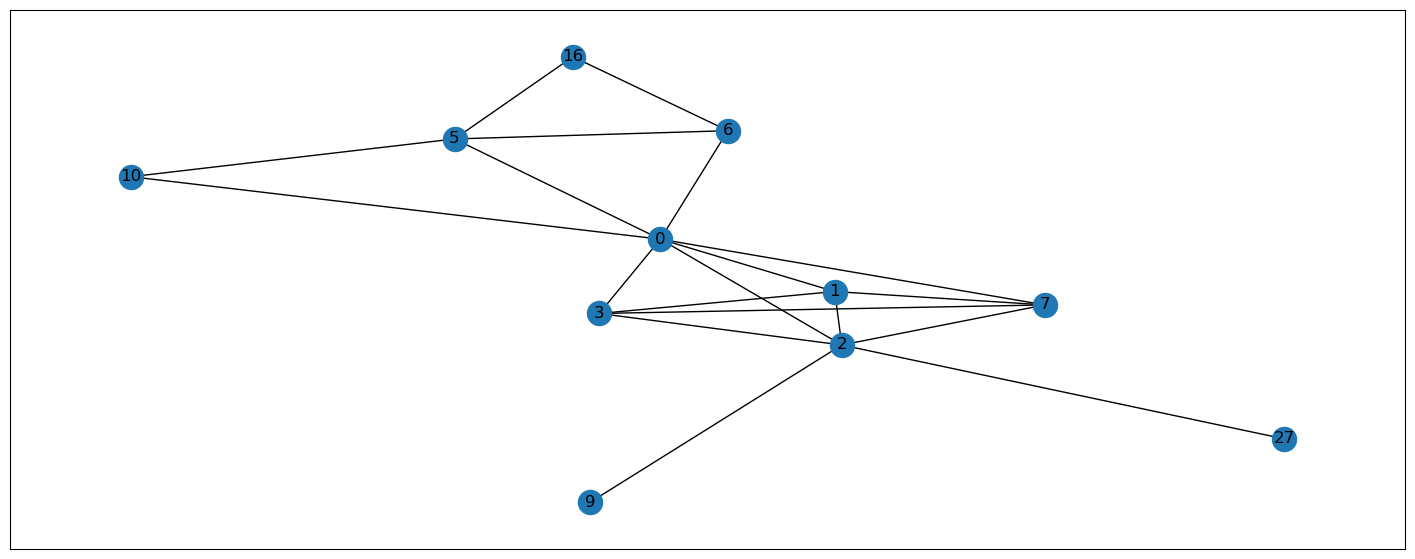

In [8]:
walk = random_walk(6, 20)  # random walk from node 6
print('Steps in random walk:', walk)

walk_graph = G.subgraph(walk)
pos = nx.spring_layout(walk_graph, seed=42)
nx.draw_networkx(walk_graph, pos=pos, cmap='coolwarm')
plt.show()

So we've generated a random walk with length of 20 starting at node 6. You can follow the steps of this walk on the graph above and see that every step is between connected nodes. By doing this walk we've got useful information about the context of the node 6. By that I mean that we now know some of the neighbours (and neighbours' neighbours) of node 6 which could be useful in classification problem for example. By repeating this random walk multiple times for all the nodes in the graph, we can get a bunch of "walk" sequences that contain useful information. The paper suggests doing around 32 walks per node with the walk length of 40. We could implement this with 2 for-loops but luckily for us, `karateclub` package has already implemented this for us (and it's much faster)

In [9]:
walker = RandomWalker(walk_length = 80, walk_number = 10)
walker.do_walks(G)  # you can access the walks in walker.walks 

### Skip-Gram

Now the question is - how can we get meaningful embeddings using the generated random walks? Well, you've ever worked with NLP you already know the answer - use the Word2Vec algorithm. In particular, we're going to use the skip-gram model with hierarchical softmax layer. There are a lot of detailed resources about the inner workings of these algorithms, but here are my favourites - Word2Vec explained by [Rasa](https://www.youtube.com/watch?v=BWaHLmG1lak) and hierarchical softmax explained by [Chris McCormick](https://www.youtube.com/watch?v=pzyIWCelt_E).

The main idea of the skip-gram model is to predict the context of a sequence from a particular node (or word). For example, if we want to train embeddings for node 6 (example above), we'll train our model (usually a simple dense neural network) with the goal to predict the nodes that appear in it's random walks. So, the model's input will be the node 6 (one-hot-encoded), middle layer will be the actual embedding, and output will be prediction of the node's context. This is a very high-level explanation and I encourage you to watch the videos above if you feel confused.
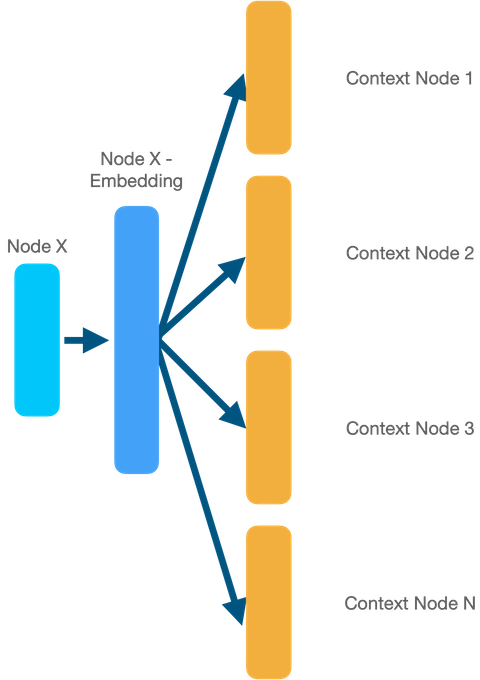

Since it's the same process as with Word2Vec, we can use the `gensim` implementation of the algorithm to get the embeddings.

In [10]:
model = Word2Vec(walker.walks,  # previously generated walks
                 hs=1,  # tells the model to use hierarchical softmax
                 sg = 1,  # tells the model to use skip-gram
                 vector_size=128,  # size of the embedding
                 window=5,
                 min_count=1,
                 workers=4,
                 seed=42)   

In [11]:
embeddings = model.wv.vectors
print('Shape of embedding matrix:', embeddings.shape)

Shape of embedding matrix: (34, 128)


And that's it! The embeddings are trained, so you can use them e.g. as features for your supervised model or to find clusters in your dataset. Let's now see how we can use DeepWalk on real classification taks.

## Twitch Data

Twitch data can be downloaded from [this repo](https://github.com/benedekrozemberczki/datasets). There's 3 files - edges, targets, and features. 

In [12]:
edges_path = 'twitch/PTBR/musae_PTBR_edges.csv'
targets_path = 'twitch/PTBR/musae_PTBR_target.csv'
features_path = 'twitch/PTBR/musae_PTBR_features.json'

In [13]:
edges = pd.read_csv(edges_path)
display(edges.head())

,from,to
0,0,92
1,0,428
2,1,689
3,1,1147
4,1,1666


In [14]:
targets = pd.read_csv(targets_path)
targets.index = targets.new_id
targets.head()

,id,days,mature,views,partner,new_id
new_id,,,,,,
1706,44891403,1943,False,929459,True,1706
1273,61180621,1633,False,11194,False,1273
313,145109685,632,False,2850,False,313
1570,122121521,906,True,3422,False,1570
800,189445819,267,False,71,False,800


In [15]:
# Reading the json as a dict
with open(features_path) as json_data:
    features = json.load(json_data)

In [16]:
max_feature = np.max([v for v_list in features.values() for v in v_list])
features_matrix = np.zeros(shape = (len(list(features.keys())), max_feature+1))

i = 0
for k, vs in tqdm(features.items()):
    for v in vs:
        features_matrix[i, v] = 1
    i+=1

100%|██████████| 1912/1912 [00:00<00:00, 147039.04it/s]


With data read in, we can build a graph now and generate the embeddings

### DeepWalk on Twitch Graph

In [17]:
graph = nx.convert_matrix.from_pandas_edgelist(edges, "from", "to")

c:\Users\34418\.conda\envs\deepwalk\lib\site-packages\networkx\drawing\nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


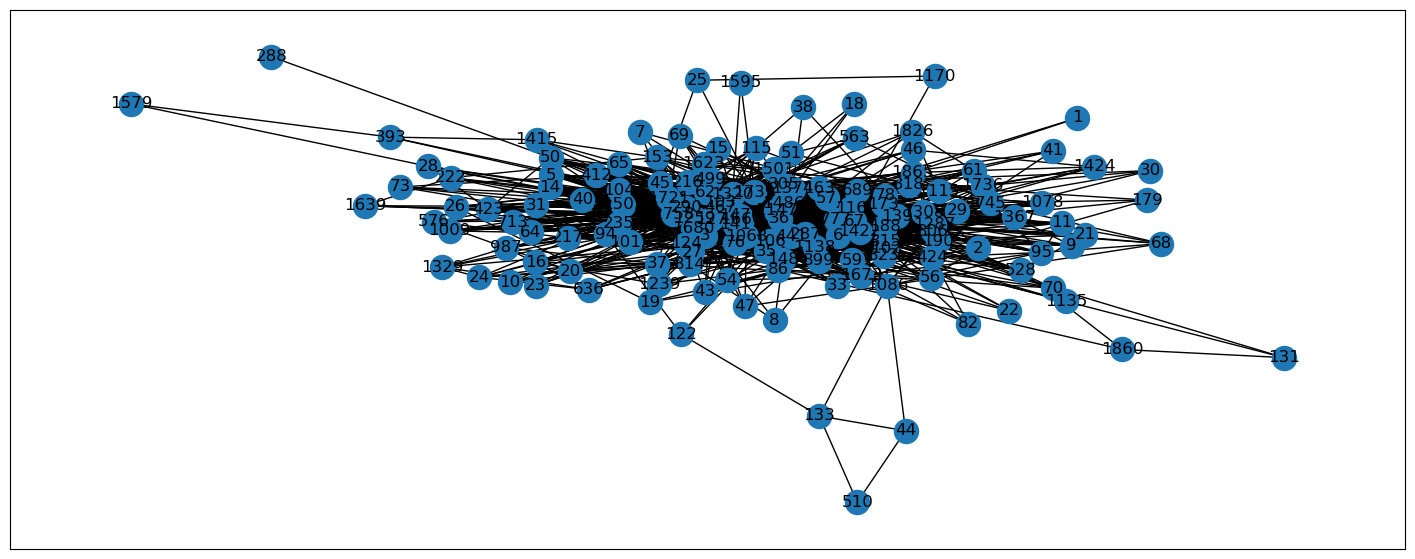

In [18]:
# Visualise some subgraph of 150 nodes
subgraph_nodes = list(nx.dfs_preorder_nodes(graph, 7))[:150] #Gets all the nodes in the graph that node 7 belongs to. 
G = graph.subgraph(subgraph_nodes)
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(G, pos=pos, cmap=plt.cm.Spectral)
plt.show()

In [19]:
# Do random walks
walker = RandomWalker(walk_length = 80, walk_number = 10)
walker.do_walks(graph)

In [20]:
model = Word2Vec(walker.walks,  # previously generated walks
                 hs=1,  # tells the model to use hierarchical softmax
                 sg = 1,  # tells the model to use skip-gram
                 vector_size=128,  # size of the embedding
                 window=10,
                 min_count=1,
                 epochs = 1,
                 workers=4,
                 seed=42)

DeepWalk model is now trained, so we can use the embeddings for classification. We can do a quick sense check of the model by looking at the nearest neighbours in the embeddings space. For example, let's check the most similar nodes to the (ID 86).

In [21]:
similar_to = '86'
targets.loc[[int(similar_to)] + [int(v[0]) for v in model.wv.most_similar(similar_to)], :].head()

,id,days,mature,views,partner,new_id
new_id,,,,,,
86,34844857,2248,False,108200,False,86
268,130339417,810,True,4637,False,268
843,146094379,623,False,9530,False,843
829,148014829,597,False,1210,False,829
1227,27535961,2398,False,1390,False,1227


As you can see, the nearest neighbours are incredibly similar to the nodes and all of this is achieved without even knowing what the nodes are about! Hence, the embeddings that the DeepWalk has learned are meaningful and we can use them in the classifier. We can build a simple Random Forest model to see what performance we can achieve using purely the embeddings.

In [22]:
# Get targets 
y = targets.loc[[int(i) for i in list(features.keys())], 'mature']

# Get corresponding embeddings
X_dw = []
for i in y.index:
    X_dw.append(model.wv.__getitem__(str(i)))

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_dw, y, test_size=0.2) # train/test split

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f1_score(y_test, y_pred, average='micro'))
print(confusion_matrix(y_test, y_pred, normalize='true'))

0.6449086161879896
[[0.97446809 0.02553191]
 [0.87837838 0.12162162]]


### Node2Vec on Twitch Graph

Node2Vec is very similar to DeepWalk, but the random walks are generated a bit differently. Recall that in the pure random walk, neighbourhood nodes have an equal propability to be chosen as next step. Here instead, we have 2 hyperparameters to tune - `p` and `q`. `p` and `q` control how fast the walk explores and leaves the neighborhood of starting node u.

* p - high values means that we're less likely to return to the previous node
* q - high values approximate the Breadth-First-Search meaning that the neighbourhood around the node is explored. Low values give higher chance to go outside the neighbourhood and hence approxiamtes the Depth-First-Search 

Let's compare 2 extreme scenarios:
1. p = 10, q = 0.1 - here we expect the random walk to go outwards and explore the adjacent clusters as well 
2. p = 0.1, q = 10 - here we expect the random walk to stay very local and explore the neighbourhood around the starting node

Here's the code block from `karate-club` package that does the Biased Random Walk. I'm showing it here so that you have a better understanding of what's happening under the hood.

In [24]:
def biased_walk(start_node, walk_length, p, q):
    walk = [start_node]
    previous_node = None
    previous_node_neighbors = []
    for _ in range(walk_length-1):
        current_node = walk[-1]  # currnet node ID
        current_node_neighbors = np.array(list(graph.neighbors(current_node)))  # negihbours of this node
        probability = np.array([1/q] * len(current_node_neighbors), dtype=float)  # outwards probability weight determined by q
        probability[current_node_neighbors==previous_node] = 1/p  # probability of return determined by p
        probability[(np.isin(current_node_neighbors, previous_node_neighbors))] = 1  # weight of 1 to all the neighbours which are connected to the previous node as well
        norm_probability = probability/sum(probability)  # normalize the probablity
        selected = np.random.choice(current_node_neighbors, 1, p=norm_probability)[0]  # select the node from neighbours according to the probabilities from above
        walk.append(selected)  # append to the walk and continue
        previous_node_neighbors = current_node_neighbors
        previous_node = current_node
    
    return walk

c:\Users\34418\.conda\envs\deepwalk\lib\site-packages\networkx\drawing\nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


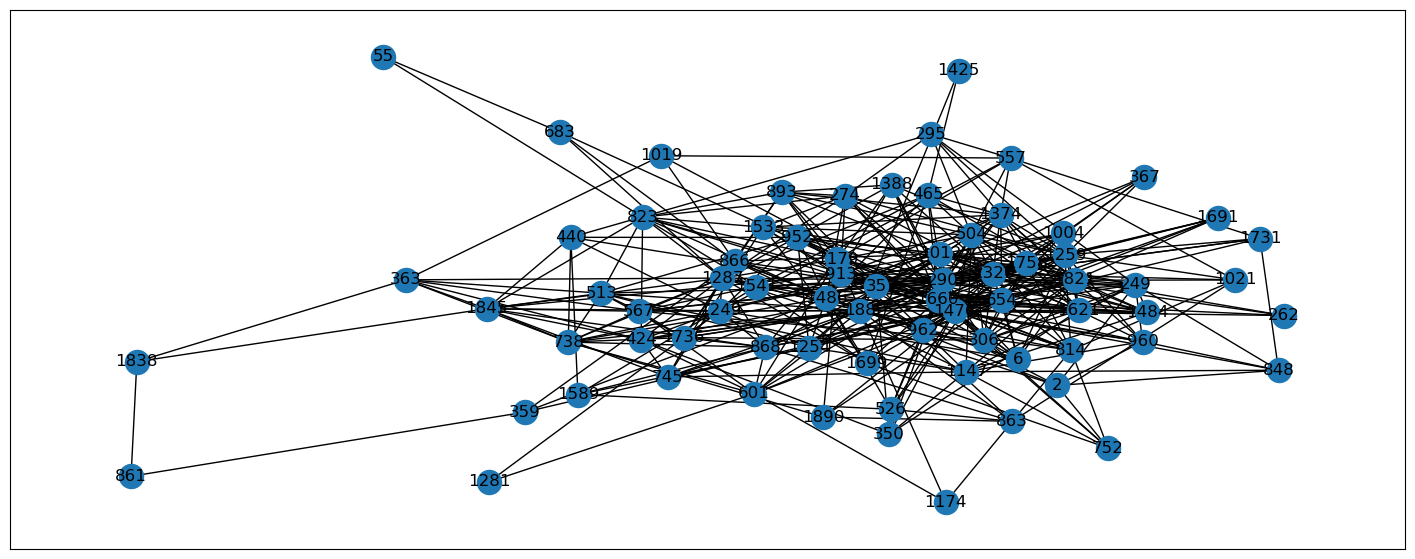

In [25]:
p = 10
q = 0.1
walk = biased_walk(6, 80, p, q)
# Visualise the subgraph
subgraph_nodes = list(nx.dfs_preorder_nodes(graph, 7))
G = graph.subgraph(walk)
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(G, pos=pos, cmap='coolwarm')
plt.show()

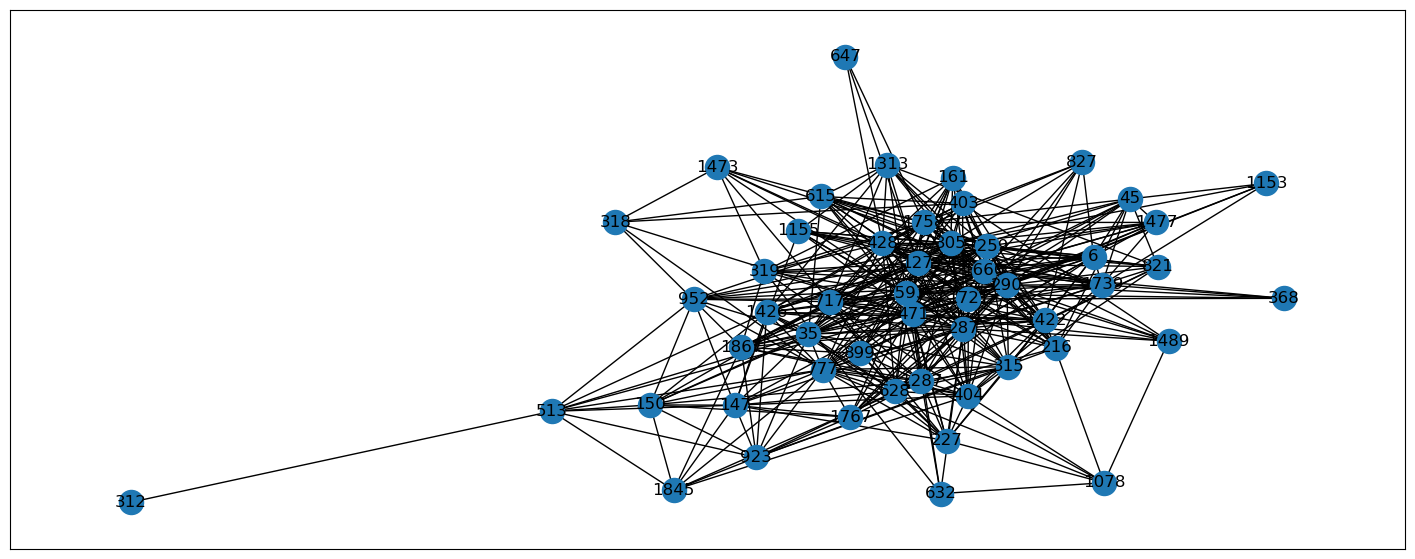

In [26]:
p = 0.1
q = 10
walk = biased_walk(6, 80, p, q)
# Visualise the subgraph
subgraph_nodes = list(nx.dfs_preorder_nodes(graph, 7)) 
G = graph.subgraph(walk)
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(G, pos=pos, cmap=plt.cm.Spectral)
plt.show()

From the images we can see the differences between the resulting random walks. Each problem will have its own perfect `p` and `q` parameters so we can treat them as hyperparameters to tune. For now, let's just set the parameters to `p=0.5` and `q=0.25` but feel free to experiment with other parameters as well. Also, we're going to use the `karate-club` implementation of `BiasedRandomWalker` for the simplicity sake. Pleasd note that biased sampling takes longer to calculate, so grid searching the optimal hyperparameters is a long procedure.

参考时间（i7-14700HX, DDR5/5600MTs）

p=0.25, q=0.5 f1=0.61 300s

p=0.1 q=10 f1=0.68 600s

In [27]:
b_walker = BiasedRandomWalker(80, 10, 0.1, 10)
b_walker.do_walks(graph)

In [28]:
node_vec = Word2Vec(b_walker.walks,  # previously generated walks
                 hs=1,  # tells the model to use hierarchical softmax
                 sg = 1,  # tells the model to use skip-gram
                 vector_size=128,  # size of the embedding
                 window=10,
                 min_count=1,
                 epochs = 1,
                 workers=4,
                 seed=42)

In [29]:
# Get corresponding Node2Vec embeddings
X_node_vec = []
for i in y.index:
    X_node_vec.append(node_vec.wv.__getitem__(str(i)))

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_node_vec, y, test_size=0.2) # train/test split

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f1_score(y_test, y_pred, average='micro'))
print(confusion_matrix(y_test, y_pred, normalize='true'))

0.6579634464751958
[[0.94354839 0.05645161]
 [0.86666667 0.13333333]]


As we can see, the results are roughly the same, so we'd need to do a proper grid-search to find the parameters that would increase the accuracy. We can also use UMAP to plot these embeddings, and see if the embeddings differ in some way.

### Comparison DeepWalk vs Node2Vec

In [31]:
dw_micro_f1_scores = []
dw_macro_f1_scores = []
for train_size in tqdm(np.arange(0.05, 1, 0.05)):
    X_train, X_test, y_train, y_test = train_test_split(X_dw, y, 
                                                        train_size=train_size,
                                                        random_state=42)

    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mic = f1_score(y_test, y_pred, average='micro')
    mac = f1_score(y_test, y_pred, average='macro')
    dw_micro_f1_scores.append(mic)
    dw_macro_f1_scores.append(mac)

100%|██████████| 19/19 [00:12<00:00,  1.51it/s]


In [32]:
nv_micro_f1_scores = []
nv_macro_f1_scores = []
for train_size in tqdm(np.arange(0.05, 1, 0.05)):
    X_train, X_test, y_train, y_test = train_test_split(X_node_vec, y, 
                                                        train_size=train_size,
                                                        random_state=42)

    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    mic = f1_score(y_test, y_pred, average='micro')
    mac = f1_score(y_test, y_pred, average='macro')
    nv_micro_f1_scores.append(mic)
    nv_macro_f1_scores.append(mac)

100%|██████████| 19/19 [00:11<00:00,  1.60it/s]


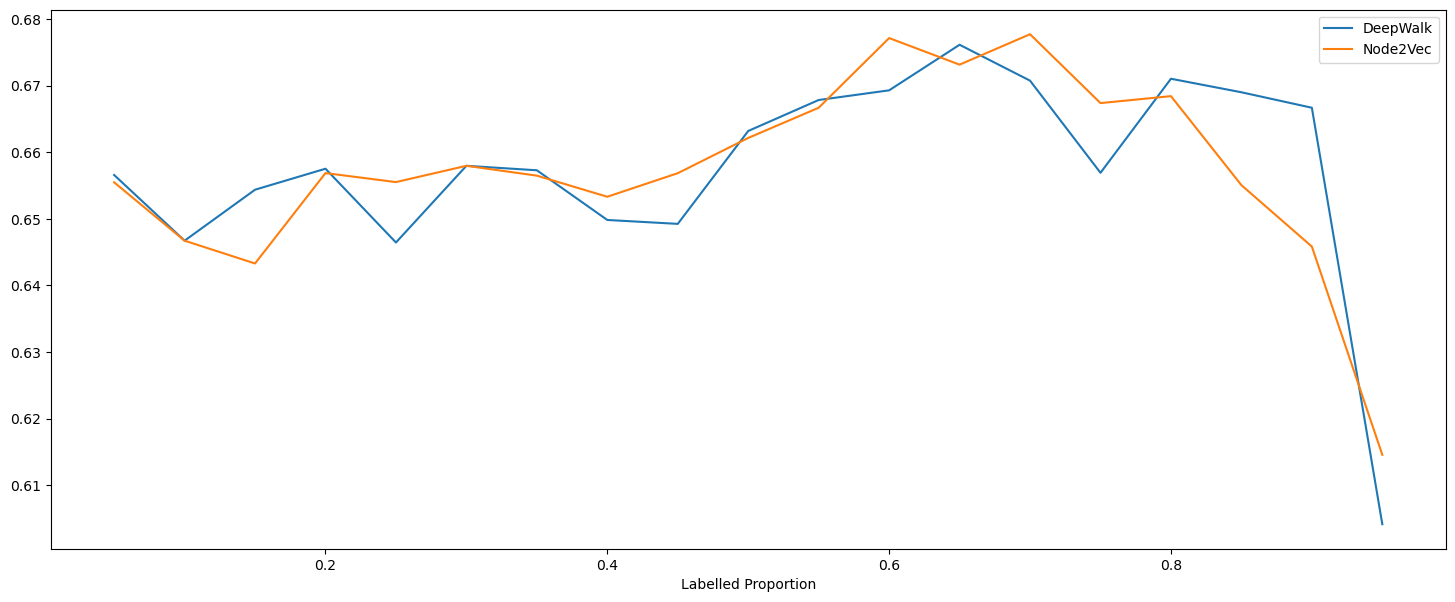

In [33]:
sns.lineplot(x = np.arange(0.05, 1, 0.05), y = dw_micro_f1_scores, label='DeepWalk')
sns.lineplot(x = np.arange(0.05, 1, 0.05), y = nv_micro_f1_scores, label='Node2Vec')
plt.xlabel('Labelled Proportion')
plt.plot()
plt.show()

c:\Users\34418\.conda\envs\deepwalk\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\34418\.conda\envs\deepwalk\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


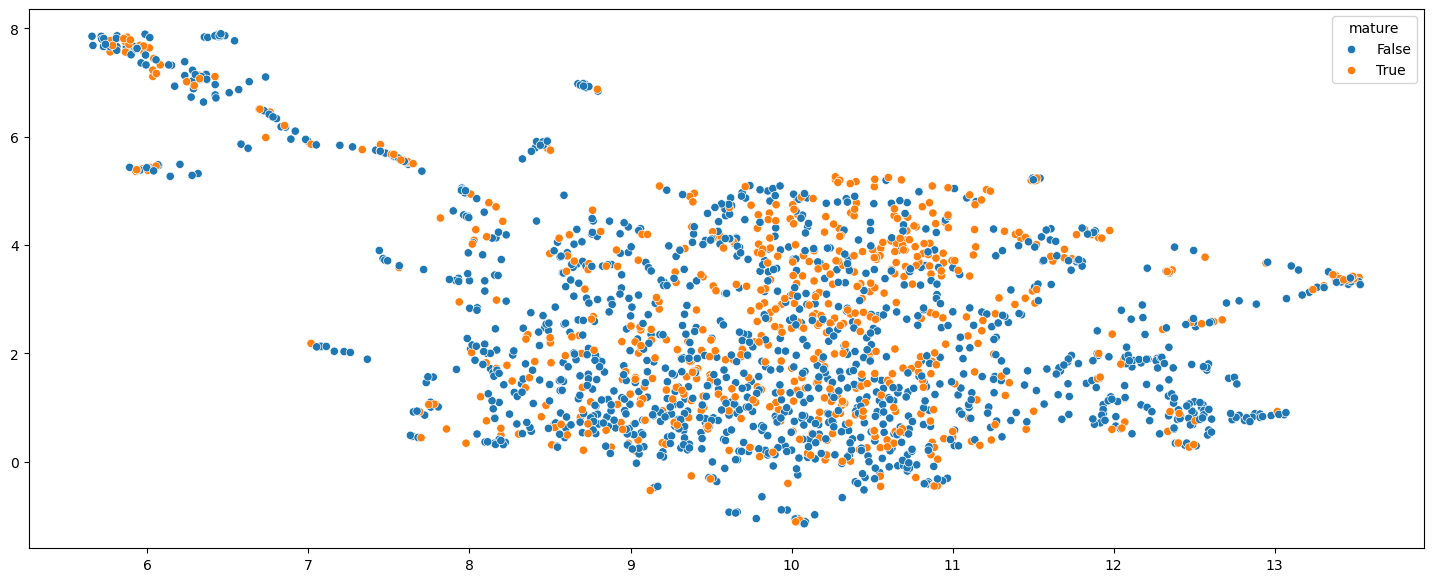

In [34]:
u = umap.UMAP(random_state=42)
dw_umap_embs = u.fit_transform(X_dw)

ax = sns.scatterplot(x = dw_umap_embs[:, 0], y = dw_umap_embs[:, 1], hue = y)
plt.show()

c:\Users\34418\.conda\envs\deepwalk\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\34418\.conda\envs\deepwalk\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


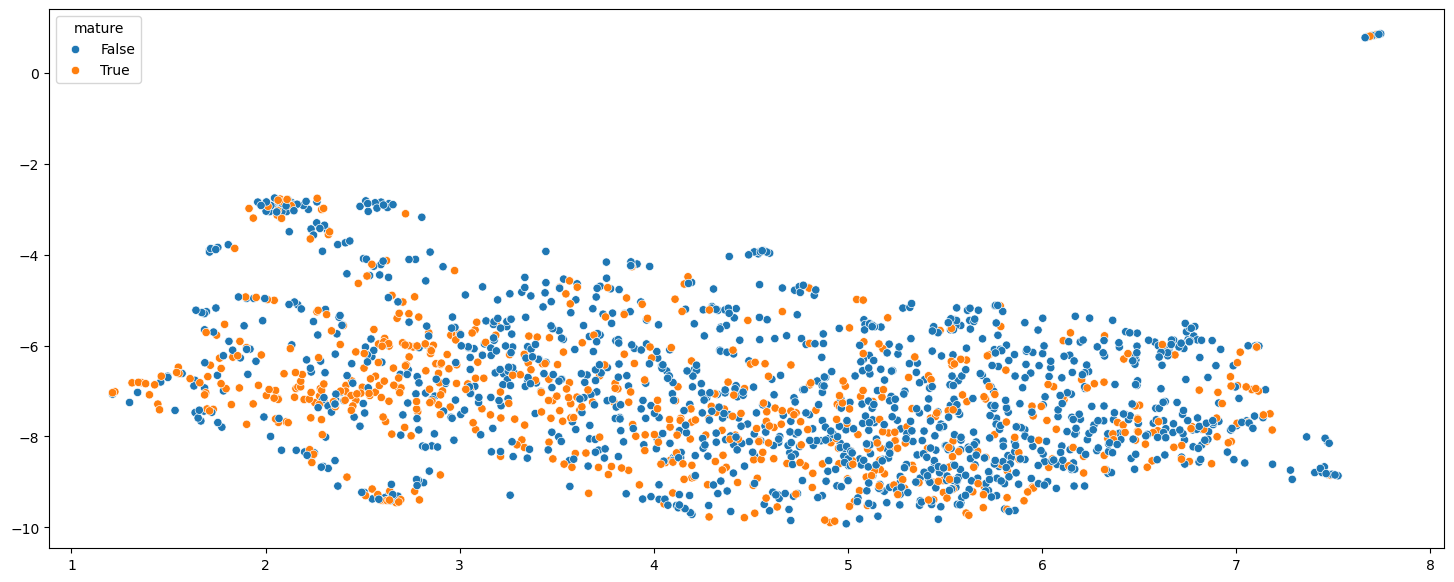

In [35]:
u = umap.UMAP(random_state=42)
nv_umap_embs = u.fit_transform(X_node_vec)

ax = sns.scatterplot(x = nv_umap_embs[:, 0], y = nv_umap_embs[:, 1], hue = y)
plt.show()

## Conclusion

Just by using structural graph information we were able to extract node embeddings which were incredibly useful in the downstream task of classifciation. Here you saw two node embedding algorithms - DeepWalk and Node2Vec. I hope that you have a better understanding of how these algorithms work, and how to apply them to the real-world graph datasets. Plus, we've covered a very important fundamental aspect of random walk, and its variant - biased random walk. These concepts are crucial in working with graphs data and you will ecnounter them in a lot of other papers. In next blogs we'll keep exploring new graph ML algorithms, so stay tuned.